In [1]:
import pandas as pd
import json

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import PercentFormatter

import math

In [8]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
  'font.size': 8,
  'text.usetex': True,
  'text.latex.preamble': r'\usepackage{amsmath}',
  'pgf.texsystem': "pdflatex",
  'pgf.preamble': r'\usepackage{amsfonts}',
  #"font.family": "serif",
  #"pgf.rcfonts": False,
})

In [2]:
fig_width=6
fig_height=1.5

In [3]:
color_i = 0
colors = {}
def get_color(fun):
    global color_i
    global colors
    
    key = fun.lower()
    if key not in colors:
        options = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS)[0:-1]
        colors[key] = options[color_i % len(options)]
        color_i += 1
    return colors[key]

def reset_colors():
    global color_i
    global colors
    color_i = 0
    colors = {}

In [4]:
results_file = f"../results.json"
with open (results_file) as file:
    data = json.load(file)
    df = pd.json_normalize(data, "benchmarks")

In [5]:
def dataset_name(d):
    return {
        'books': "amazon", 
        'fb': "facebook", 
        'gap_10': "gapped 10%", 
        'normal': "normal", 
        'osm': "open street map", 
        'seq': "sequential", 
        'uniform': "uniform", 
        'wiki': "wikipedia"
    }[d]
    
def get_dataset_order(d):
    return {ds: i for i, ds in enumerate([
        'seq',
        'gap_10',
        'normal',
        'uniform',
        'books',
        'wiki',
        'fb',
        'osm',
    ])}[d]

def human_func_name(f):
    return {
        'fibonacci': "Fibonacci",
        'murmur3': "Murmur3",
        'radixspline': "RS ($\epsilon = 4, r = 18$)",
        'triespline': "PLEX ($\epsilon = 4$)"
    }[f]

def human_probe_method_name(pm):
    return {
        'linear_probing': "Linear Probing",
        'quadratic_probing': "Quadratic Probing",
    }[pm]

def get_marker(f):
    return {
        'fibonacci': "*",
        'murmur3': "+",
        'radixspline': "v",
        'triespline': "^"
    }[f]

def map_probe_dist(d):
    return {'0': "uniform", '1': "exponential"}[d]

In [6]:
label = "label"
func_name = "fn_name"
dataset = "dataset"
dataset_size = "dataset_size"
dataset_order = "dataset_order"
overallocation = "overallocation"

failed = "failed"
failed_at = "failed_at"
average_psl = "average_psl"
max_psl = "max_psl"
min_psl = "min_psl"
total_psl = "total_psl"
probing_method = "probing_method"

hashtable_bytes = "hashtable_bytes"
hashtable_bytes_per_key = "hashtable_bytes_per_key"
total_bytes = "total_bytes"
hashtable_lookup = "cpu_time"
build_time = "build_time"
build_throughput = "build_throughput"
build_ns_per_key = "build_ns_per_key"
probing_distribution = "probing_distribution"

def extract_fun_name(x):
    raw = x[x.find("hashing::"):x.find(">")].removeprefix("hashing::").lower()
    if raw.startswith("triespline"):
        return "triespline"
    if raw.startswith("radixspline"):
        return "radixspline"
    if raw.startswith("murmur"):
        return "murmur3"
    if raw.startswith("fibonacci"):
        return "fibonacci"

probing_df = df[df["name"].str.startswith("BM_hashtable") & df["name"].str.contains("::Probing") & (df[failed] < 1.0)].copy(deep=True)
probing_df[func_name] = probing_df["name"].apply(extract_fun_name)
probing_df[dataset] = probing_df["label"].apply(lambda x : x.split(":")[1])
probing_df[dataset_order] = probing_df[dataset].apply(get_dataset_order)

probing_df[probing_method] = probing_df["label"].apply(lambda x : x.split(":")[0])
probing_df[probing_distribution] = probing_df["name"].apply(lambda x: map_probe_dist(x.split('/')[-2]))
probing_df[hashtable_bytes_per_key] = probing_df.apply(lambda x: x[hashtable_bytes] / x[dataset_size], axis=1)
probing_df[build_throughput] = probing_df.apply(lambda x: x[dataset_size] / x[build_time], axis=1)
probing_df[build_ns_per_key] = probing_df.apply(lambda x: 10**9 * x[build_time] / x[dataset_size], axis=1)

# pd.set_option('display.max_columns', None)  # or 1000
# pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', None)  # or 199
# probing_df[[func_name, probing_method, dataset, dataset_size, overallocation, probing_distribution, hashtable_bytes_per_key, failed, failed_at, average_psl, hashtable_lookup, build_time, build_throughput, build_ns_per_key]]

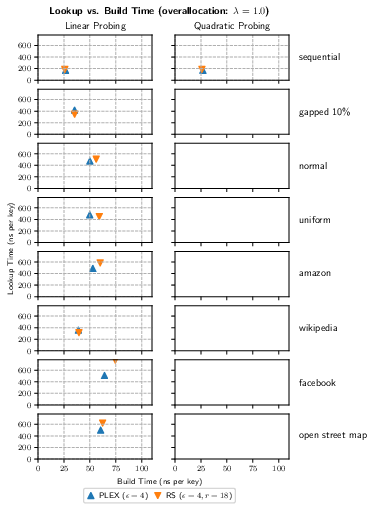

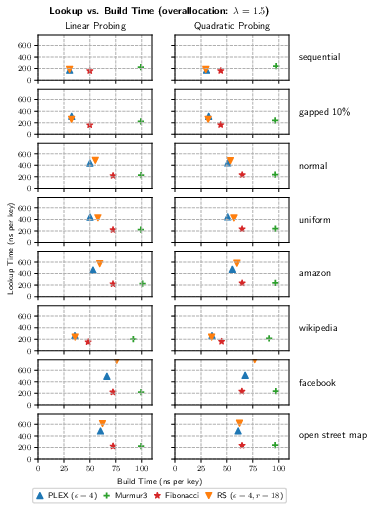

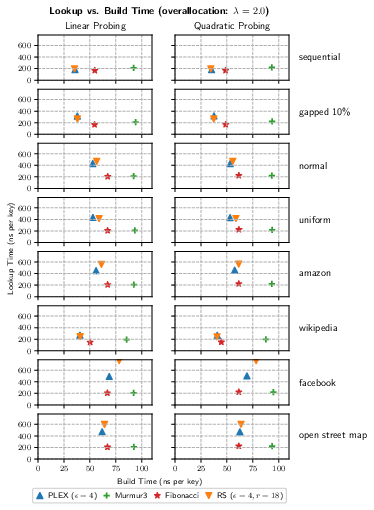

In [10]:
def plot_pareto(data, overalloc, probing_dist="uniform"):
    rows = 8
    cols = 2
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.75, fig_height*rows*0.65), sharex=True, sharey=True)
    
    data = data[(data[overallocation] == overalloc) & (data[probing_distribution] == probing_dist)].copy(deep=True).sort_values(by=[dataset_order, dataset_size])
    for i, (ds, df) in enumerate(data.groupby([dataset], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset_name(ds), 
            xy=(0, 0.5),
            xytext=(120 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='left', 
            va='center',
            rotation=0
        )
        
        for j, (probe_meth, df) in enumerate(df.groupby([probing_method], sort=False)):
            ax = axs[i][j]
            if i == 0:
                ax.set_title(human_probe_method_name(probe_meth))

            ax.grid(linestyle='--', axis='both')
            ax.set_xlim([0, 110])
            ax.set_xticks([0, 25, 50, 75, 100])
            ax.set_ylim([0, 780])
            ax.set_yticks([0, 200, 400, 600])

            for name, df in df.groupby([func_name], sort=False):
                ax.scatter(x=df[build_ns_per_key], y=df[hashtable_lookup], label=human_func_name(name), color=get_color(name), marker=get_marker(name))
                
    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(
        h, l,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.04),
        ncol=4,
        borderpad=0.4, 
        labelspacing=0.2, 
        handlelength=1.0, 
        handletextpad=0.5, 
        columnspacing=0.7
    )

    fig.suptitle(f"Lookup vs. Build Time (overallocation: $\lambda = {overalloc}$)", y=0.93, fontweight="bold")
    fig.text(0.03, 0.5, 'Lookup Time (ns per key)', va='center', rotation='vertical')
    fig.text(0.5, 0.08, 'Build Time (ns per key)', ha='center')
        
    fig.savefig(f"probing_build_{overalloc}.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"probing_build_{overalloc}.pgf", bbox_inches="tight", dpi=300)

for overalloc in [1.0, 1.5, 2.0]:
    plot_pareto(probing_df, overalloc=overalloc)

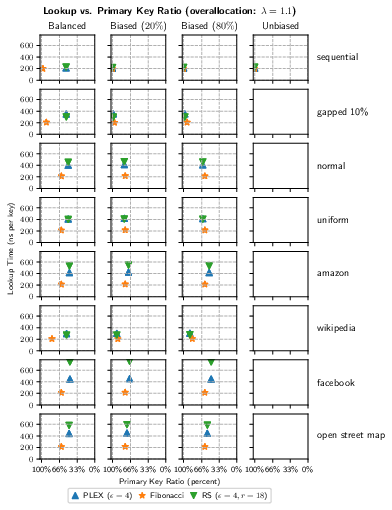

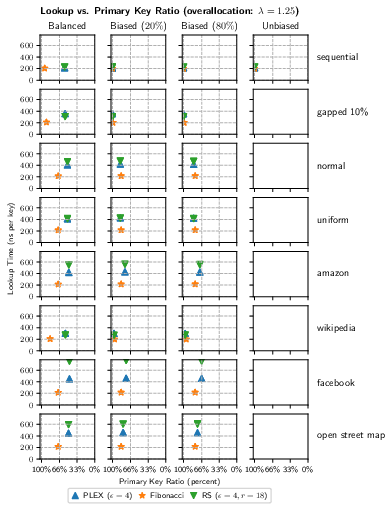

In [93]:
# def plot_primary_key_ratio(data, overalloc):
#     rows = 8
#     cols = 4
    
#     fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.8, fig_height*rows*0.65), sharex=True, sharey=True)
    
#     data = data[data[overallocation] == overalloc].copy(deep=True).sort_values(by=[dataset_order, dataset_size])
#     for i, (ds, df) in enumerate(data.groupby([dataset], sort=False)):
#         pad = 7.5
#         axs[i][-1].annotate(
#             dataset_name(ds), 
#             xy=(0, 0.5),
#             xytext=(60 + axs[i][-1].yaxis.labelpad + pad, 0),
#             xycoords=axs[i][-1].yaxis.label, 
#             textcoords='offset points',
#             size='large', 
#             ha='left', 
#             va='center',
#             rotation=0
#         )
        
#         for j, (kicking_strat, df) in enumerate(df.groupby([kicking_strategy], sort=False)):
#             ax = axs[i][j]                        
#             if i == 0:
#                 ax.set_title(human_kicking_name(kicking_strat))
    
#             for k, (name, df) in enumerate(df.groupby([func_name], sort=False)):
#                 ax.scatter(x=df[primary_key_ratio], y=df[hashtable_lookup], label=human_func_name(name), color=get_color(name), marker=get_marker(name))
        
#             ax.grid(linestyle='--', axis='both')
#             ax.set_xticks([1.0, 0.66, 0.33, 0])
#             ax.xaxis.set_major_formatter(PercentFormatter(xmax=1.0))
#             ax.invert_xaxis()
#             # for tick in ax.get_xticks():
#             #     tick.set_rotation(90)
#             ax.set_ylim([0, 780])
#             ax.set_yticks([0, 200, 400, 600])
                
#     h, l = axs[0][0].get_legend_handles_labels()
#     legend = fig.legend(
#         h, l,
#         loc="lower center",
#         bbox_to_anchor=(0.5, 0.04),
#         ncol=4,
#         borderpad=0.4, 
#         labelspacing=0.2, 
#         handlelength=1.0, 
#         handletextpad=0.5, 
#         columnspacing=0.7
#     )

#     fig.suptitle(f"Lookup vs. Primary Key Ratio (overallocation: $\lambda = {overalloc}$)", y=0.93, fontweight="bold")
#     fig.text(0.03, 0.5, 'Lookup Time (ns per key)', va='center', rotation='vertical')
#     fig.text(0.5, 0.08, 'Primary Key Ratio (percent)', ha='center')
#     fig.subplots_adjust(wspace=0.3)
        
#     fig.savefig(f"cuckoo_primary_key_ratio_{overalloc}.pdf", bbox_inches="tight", dpi=300)
#     fig.savefig(f"cuckoo_primary_key_ratio_{overalloc}.pgf", bbox_inches="tight", dpi=300)

# for overalloc in [1.10, 1.25]:
#     plot_primary_key_ratio(cuckoo_df, overalloc=overalloc)